In [82]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency, f_oneway
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score

In [5]:
# Load the dataset
a1 = pd.read_excel("D:\DS_ML\My Projects\Credit Risk Default Prediction\My Solution\CreditDefaultData\case_study1.xlsx")
a2 = pd.read_excel("D:\DS_ML\My Projects\Credit Risk Default Prediction\My Solution\CreditDefaultData\case_study2.xlsx")

In [56]:
df1 = a1.copy()
df2 = a2.copy()

In [57]:
# Remove nulls
df1 = df1.loc[df1['Age_Oldest_TL'] != -99999]

columns_to_be_removed = []

for i in df2.columns:
    if df2.loc[df2[i] == -99999].shape[0] > 10000:
        columns_to_be_removed .append(i)

df2 = df2.drop(columns_to_be_removed, axis=1)


for i in df2.columns:
    df2 = df2.loc[ df2[i] != -99999 ]

In [58]:
df = pd.merge(df1, df2, on='PROSPECTID', how='inner')

In [59]:
df.shape

(42064, 79)

In [60]:
df = df.drop('PROSPECTID', axis=1)

In [61]:
X = df.drop('Approved_Flag', axis=1)
y = df['Approved_Flag']

In [62]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [63]:
categorical_feat = [col for col in X_train.columns if X_train[col].dtype == 'O']
numerical_feat = [col for col in X_train.columns if X_train[col].dtype != 'O']

In [64]:
# Multicolinearity Checking
vif_data = X_train[numerical_feat]
total_no_of_numfeat = vif_data.shape[1]
columns_to_be_kept = []
column_index = 0

for i in range(total_no_of_numfeat):
    vif_value = variance_inflation_factor(vif_data, column_index)
    # print (column_index,'---',vif_value)

    if vif_value <= 6:
        columns_to_be_kept.append(numerical_feat[i])
        column_index += 1
    
    else:
        vif_data = vif_data.drop(numerical_feat[i], axis=1)

d:\DS_ML\ML_DL_AI\venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
d:\DS_ML\ML_DL_AI\venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
d:\DS_ML\ML_DL_AI\venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
d:\DS_ML\ML_DL_AI\venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)
d:\DS_ML\ML_DL_AI\venv\lib\site-packages\statsmodels\stats\outliers_influence.py:197: RuntimeWarning: divide by zero encountered in scalar divide
  vif = 1. / (1. - r_squared_i)


In [65]:
# check Anova for columns_to_be_kept 
columns_to_be_kept_numerical = []

for i in columns_to_be_kept:
    a = list(df[i])  
    b = list(df['Approved_Flag'])  
    
    group_P1 = [value for value, group in zip(a, b) if group == 'P1']
    group_P2 = [value for value, group in zip(a, b) if group == 'P2']
    group_P3 = [value for value, group in zip(a, b) if group == 'P3']
    group_P4 = [value for value, group in zip(a, b) if group == 'P4']


    f_statistic, p_value = f_oneway(group_P1, group_P2, group_P3, group_P4)

    if p_value <= 0.05:
        columns_to_be_kept_numerical.append(i)

In [66]:
# listing all the final features
features = columns_to_be_kept_numerical + categorical_feat
len(features)

42

In [67]:
X_train = X_train[features]
X_test = X_test[features]

In [68]:
education_mapping = {
    'SSC': 1,
    'OTHERS': 1,
    '12TH': 2,
    'GRADUATE': 3,
    'UNDER GRADUATE': 3,
    'PROFESSIONAL': 3,
    'POST-GRADUATE': 4
}
X_train['EDUCATION'] = X_train['EDUCATION'].map(education_mapping)
X_test['EDUCATION'] = X_test['EDUCATION'].map(education_mapping)

In [69]:
X_train['EDUCATION'] = X_train['EDUCATION'].astype(int)
X_test['EDUCATION'] = X_test['EDUCATION'].astype(int)

In [70]:
X_train = pd.get_dummies(X_train, columns=['MARITALSTATUS','GENDER', 'last_prod_enq2' ,'first_prod_enq2'])
X_test = pd.get_dummies(X_test, columns=['MARITALSTATUS','GENDER', 'last_prod_enq2' ,'first_prod_enq2'])

In [71]:
numerical_feat = X_train.select_dtypes(exclude="object").columns
numeric_transformer = StandardScaler()
preprocessor = ColumnTransformer(
    [
        ("StandardScaler", numeric_transformer, numerical_feat)
    ]
)

In [72]:
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [74]:
model = AdaBoostClassifier()

In [75]:
model.fit(X_train, y_train)

,estimator,None
,n_estimators,50
,learning_rate,1.0
,algorithm,'deprecated'
,random_state,None


In [81]:
predictions = model.predict(X_test)
predictions

array(['P2', 'P4', 'P2', ..., 'P2', 'P2', 'P4'],
      shape=(8413,), dtype=object)

In [ ]:
error_rates = []
for n in range(1,201):
    model  = AdaBoostClassifier(n_estimators=n)
    model.fit(X_train, y_train)
    predictions = model.predict(X_test)
    error = 1 - accuracy_score(y_test,predictions)
    error_rates.append(error)

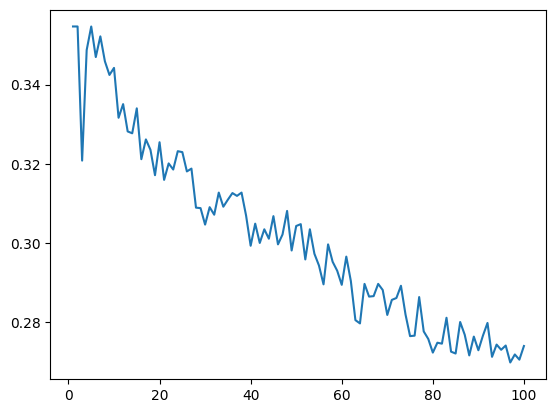

In [84]:
plt.plot(range(1,101), error_rates)
plt.show()